In [28]:
# Hack to always autoreload modules and avoid restarting the kernel each time

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Note: This is a hack to allow importing from the parent directory
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))

In [38]:
!pip install optuna optuna-dashboard

In [3]:
import optuna
from optuna_dashboard import run_server
import torch
from models.gaussian_image_trainer import GaussianImageTrainer
from configs import Config
from utils.search_space import is_valid_combination

Files already downloaded and verified


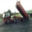

In [4]:
import torchvision
from constants import CIFAR10_TRANSFORM
from utils.data import create_default_image
from utils import visualize_tensor

dataset = torchvision.datasets.CIFAR10(root="./data", download=True)
cifar_image = CIFAR10_TRANSFORM(dataset[2][0])
visualize_tensor(cifar_image)

In [11]:
import logging
import sys

In [16]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "test-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)

[I 2025-01-06 06:09:57,496] Using an existing study with name 'test-study' instead of creating a new one.


Using an existing study with name 'test-study' instead of creating a new one.
Using an existing study with name 'test-study' instead of creating a new one.
Using an existing study with name 'test-study' instead of creating a new one.
Using an existing study with name 'test-study' instead of creating a new one.


In [17]:
def objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna hyperparameter optimization.

    Args:
        trial (optuna.Trial): The trial object used to suggest hyperparameters.

    Returns:
        float: The evaluation metric to minimize (e.g., validation loss).
    """
    # Conditional sampling
    # group_optimization = trial.suggest_categorical("group_optimization", [True, False])
    # strategy = None
    group_optimization = True # For now, as having default strategy was causing an error
    if not group_optimization:
        strategy = trial.suggest_categorical("strategy", ["default", "mcmc"])

    # Hyperparameter suggestions
    loss_weights = [
        trial.suggest_float("loss_weight_l1", 0.1, 1.0),
        trial.suggest_float("loss_weight_mse", 0.1, 1.0),
        trial.suggest_float("loss_weight_ssim", 0.1, 1.0),
    ]
    loss_weights = [w / sum(loss_weights) for w in loss_weights]

    scale_regulation = trial.suggest_categorical("scale_regulation", [None, 0.1, 0.5, 1.0])
    opacity_regulation = trial.suggest_categorical("opacity_regulation", [None, 0.1, 0.5, 1.0])

    init_type = trial.suggest_categorical("init_type", ["random", "grid", "knn"])
    num_points = trial.suggest_categorical("num_points", [16*16, 24*24, 32*32, 64*64])
    extent = trial.suggest_categorical("extent", [1.0, 2.0, 4.0])
    init_scale = trial.suggest_float("init_scale", 0.5, 2.0)
    init_opacity = trial.suggest_float("init_opacity", 0.1, 1.0)

    max_steps = trial.suggest_int("max_steps", 250, 10000, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True) if group_optimization else None

    model_type = trial.suggest_categorical("model_type", ["2dgs", "3dgs"])  # Left out "2dgs-inria" as it needed further dependencies
    bilateral_grid = trial.suggest_categorical("bilateral_grid", [True, False])

    if not is_valid_combination({
        "learning_rate": learning_rate,
        "loss_weights": loss_weights,
        "group_optimization": group_optimization,
        # "strategy": strategy,
        "learning_rate": learning_rate,
        "model_type": model_type,
        "bilateral_grid": bilateral_grid,
    }, GaussianImageTrainer):
        raise optuna.exceptions.TrialPruned("Invalid hyperparameter combination")

    # Create Config object
    cfg = Config(
        
        seed=42,
        image=cifar_image,  # Replace with actual ground truth image tensor
        max_steps=max_steps,
        learning_rate=learning_rate,
        loss_weights=loss_weights,
        init_type=init_type,
        num_points=num_points,
        init_scale=init_scale,
        init_opacity=init_opacity,
        group_optimization=group_optimization,
        # strategy=strategy,
        model_type=model_type,
        # bilateral_grid=bilateral_grid,
        bilateral_grid=False
    )

    # Initialize and train the model
    trainer = GaussianImageTrainer(cfg)
    result = trainer.train()

    # Evaluate generated image quality (e.g., L1 loss with ground truth)
    generated_image = result.cpu()  # Replace with actual rendered output
    ground_truth_image = cfg.image.cpu()
    evaluation_metric = torch.nn.functional.l1_loss(generated_image, ground_truth_image)

    return evaluation_metric.item()

In [18]:
def run_optimization():
    """
    Run Optuna optimization and optionally launch a dashboard for monitoring.
    """
    study.optimize(objective, n_trials=10, n_jobs=1, timeout=3600)  # Parallelize with n_jobs

    print("Best hyperparameters found:")
    print(study.best_trial.params)

    # # Save the study
    # study_path = "./optuna_study.pkl"
    # with open(study_path, "wb") as f:
    #     optuna.study.save_study(study, f)

    # # Launch Optuna dashboard for monitoring
    # try:
    #     run_server(study, host="127.0.0.1", port=5000)
    # except KeyboardInterrupt:
    #     print("Dashboard stopped.")

    # # Visualization (if needed)
    # try:
    #     import optuna.visualization as vis
    #     vis.plot_optimization_history(study).show()
    #     vis.plot_param_importances(study).show()
    # except ImportError:
    #     print("Visualization libraries not installed.")

Model initialized. Number of Gaussians: 576


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/functional/image/lpips.py:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

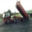

JPG image saved to: results/original.jpg


Loss: 0.691 (L1: 0.479, MSE: 0.341, SSIM: 0.992):   0%|                  | 0/4929 [00:00<?, ?step/s]

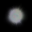

Loss: 0.691 (L1: 0.479, MSE: 0.341, SSIM: 0.991):   0%|        | 18/4929 [00:00<00:27, 176.84step/s]

JPG image saved to: results/step_00000.jpg


Loss: 0.690 (L1: 0.479, MSE: 0.341, SSIM: 0.990):   2%|▏       | 99/4929 [00:00<00:26, 179.12step/s]

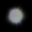

Loss: 0.689 (L1: 0.479, MSE: 0.341, SSIM: 0.989):   3%|▏      | 141/4929 [00:00<00:24, 192.99step/s]

JPG image saved to: results/step_00100.jpg


Loss: 0.689 (L1: 0.479, MSE: 0.341, SSIM: 0.988):   4%|▎      | 184/4929 [00:01<00:23, 200.91step/s]

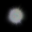

Loss: 0.688 (L1: 0.479, MSE: 0.341, SSIM: 0.987):   5%|▎      | 226/4929 [00:01<00:23, 201.13step/s]

JPG image saved to: results/step_00200.jpg


Loss: 0.688 (L1: 0.479, MSE: 0.340, SSIM: 0.986):   6%|▍      | 289/4929 [00:01<00:23, 196.51step/s]

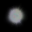

Loss: 0.687 (L1: 0.479, MSE: 0.340, SSIM: 0.985):   7%|▍      | 329/4929 [00:01<00:24, 187.42step/s]

JPG image saved to: results/step_00300.jpg


Loss: 0.687 (L1: 0.478, MSE: 0.340, SSIM: 0.984):   8%|▌      | 387/4929 [00:02<00:24, 182.71step/s]

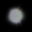

Loss: 0.686 (L1: 0.478, MSE: 0.340, SSIM: 0.983):   9%|▌      | 425/4929 [00:02<00:25, 177.29step/s]

JPG image saved to: results/step_00400.jpg


Loss: 0.685 (L1: 0.478, MSE: 0.340, SSIM: 0.982):  10%|▋      | 484/4929 [00:02<00:24, 184.95step/s]

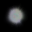

Loss: 0.685 (L1: 0.478, MSE: 0.340, SSIM: 0.981):  11%|▋      | 524/4929 [00:02<00:23, 186.36step/s]

JPG image saved to: results/step_00500.jpg


Loss: 0.684 (L1: 0.478, MSE: 0.340, SSIM: 0.980):  12%|▊      | 590/4929 [00:03<00:21, 204.07step/s]

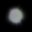

Loss: 0.684 (L1: 0.478, MSE: 0.340, SSIM: 0.979):  13%|▉      | 633/4929 [00:03<00:20, 205.09step/s]

JPG image saved to: results/step_00600.jpg


Loss: 0.683 (L1: 0.478, MSE: 0.340, SSIM: 0.978):  14%|▉      | 699/4929 [00:03<00:20, 210.78step/s]

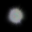

Loss: 0.683 (L1: 0.478, MSE: 0.340, SSIM: 0.977):  15%|█      | 743/4929 [00:03<00:19, 210.39step/s]

JPG image saved to: results/step_00700.jpg


Loss: 0.682 (L1: 0.478, MSE: 0.340, SSIM: 0.976):  16%|█      | 786/4929 [00:04<00:20, 205.05step/s]

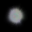

Loss: 0.682 (L1: 0.478, MSE: 0.340, SSIM: 0.976):  17%|█▏     | 828/4929 [00:04<00:20, 198.46step/s]

JPG image saved to: results/step_00800.jpg


Loss: 0.681 (L1: 0.477, MSE: 0.339, SSIM: 0.974):  18%|█▎     | 888/4929 [00:04<00:20, 195.99step/s]

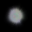

Loss: 0.681 (L1: 0.477, MSE: 0.339, SSIM: 0.973):  19%|█▎     | 944/4929 [00:04<00:16, 238.92step/s]

JPG image saved to: results/step_00900.jpg


Loss: 0.680 (L1: 0.477, MSE: 0.339, SSIM: 0.973):  20%|█▍     | 975/4929 [00:04<00:15, 259.78step/s]

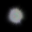

Loss: 0.680 (L1: 0.477, MSE: 0.339, SSIM: 0.972):  21%|█▎    | 1033/4929 [00:05<00:14, 262.91step/s]

JPG image saved to: results/step_01000.jpg


Loss: 0.679 (L1: 0.477, MSE: 0.339, SSIM: 0.971):  22%|█▎    | 1086/4929 [00:05<00:16, 229.78step/s]

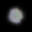

Loss: 0.679 (L1: 0.477, MSE: 0.339, SSIM: 0.970):  23%|█▍    | 1133/4929 [00:05<00:18, 210.47step/s]

JPG image saved to: results/step_01100.jpg


Loss: 0.678 (L1: 0.477, MSE: 0.339, SSIM: 0.969):  24%|█▍    | 1197/4929 [00:05<00:19, 193.05step/s]

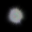

Loss: 0.678 (L1: 0.477, MSE: 0.339, SSIM: 0.968):  25%|█▌    | 1237/4929 [00:06<00:19, 185.61step/s]

JPG image saved to: results/step_01200.jpg


Loss: 0.677 (L1: 0.477, MSE: 0.339, SSIM: 0.967):  26%|█▌    | 1299/4929 [00:06<00:18, 195.61step/s]

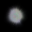

Loss: 0.677 (L1: 0.477, MSE: 0.339, SSIM: 0.967):  27%|█▌    | 1319/4929 [00:06<00:18, 190.55step/s]

JPG image saved to: results/step_01300.jpg


Loss: 0.676 (L1: 0.476, MSE: 0.338, SSIM: 0.965):  28%|█▋    | 1396/4929 [00:07<00:19, 183.89step/s]

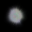

Loss: 0.676 (L1: 0.476, MSE: 0.338, SSIM: 0.965):  29%|█▋    | 1415/4929 [00:07<00:20, 174.26step/s]

JPG image saved to: results/step_01400.jpg


Loss: 0.675 (L1: 0.476, MSE: 0.338, SSIM: 0.964):  30%|█▊    | 1485/4929 [00:07<00:20, 165.14step/s]

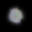

Loss: 0.675 (L1: 0.476, MSE: 0.338, SSIM: 0.963):  31%|█▊    | 1519/4929 [00:07<00:21, 160.38step/s]

JPG image saved to: results/step_01500.jpg


Loss: 0.674 (L1: 0.476, MSE: 0.338, SSIM: 0.962):  32%|█▉    | 1589/4929 [00:08<00:19, 169.17step/s]

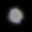

Loss: 0.674 (L1: 0.476, MSE: 0.338, SSIM: 0.961):  33%|█▉    | 1624/4929 [00:08<00:19, 168.97step/s]

JPG image saved to: results/step_01600.jpg


Loss: 0.674 (L1: 0.476, MSE: 0.338, SSIM: 0.960):  34%|██    | 1697/4929 [00:08<00:19, 167.01step/s]

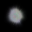

Loss: 0.673 (L1: 0.476, MSE: 0.338, SSIM: 0.960):  35%|██    | 1735/4929 [00:09<00:18, 177.35step/s]

JPG image saved to: results/step_01700.jpg


Loss: 0.673 (L1: 0.476, MSE: 0.338, SSIM: 0.959):  36%|██▏   | 1795/4929 [00:09<00:16, 185.90step/s]

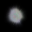

Loss: 0.672 (L1: 0.476, MSE: 0.338, SSIM: 0.958):  37%|██▏   | 1814/4929 [00:09<00:17, 181.84step/s]

JPG image saved to: results/step_01800.jpg


Loss: 0.672 (L1: 0.475, MSE: 0.337, SSIM: 0.957):  38%|██▎   | 1886/4929 [00:09<00:18, 167.67step/s]

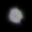

Loss: 0.671 (L1: 0.475, MSE: 0.337, SSIM: 0.956):  39%|██▎   | 1924/4929 [00:10<00:17, 176.33step/s]

JPG image saved to: results/step_01900.jpg


Loss: 0.671 (L1: 0.475, MSE: 0.337, SSIM: 0.955):  40%|██▍   | 1989/4929 [00:10<00:14, 198.99step/s]

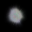

Loss: 0.670 (L1: 0.475, MSE: 0.337, SSIM: 0.955):  41%|██▍   | 2031/4929 [00:10<00:14, 203.18step/s]

JPG image saved to: results/step_02000.jpg


Loss: 0.670 (L1: 0.475, MSE: 0.337, SSIM: 0.954):  43%|██▌   | 2097/4929 [00:10<00:13, 210.30step/s]

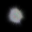

Loss: 0.670 (L1: 0.475, MSE: 0.337, SSIM: 0.953):  43%|██▌   | 2140/4929 [00:11<00:13, 208.05step/s]

JPG image saved to: results/step_02100.jpg


Loss: 0.669 (L1: 0.475, MSE: 0.337, SSIM: 0.952):  44%|██▋   | 2182/4929 [00:11<00:13, 199.47step/s]

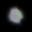

Loss: 0.669 (L1: 0.475, MSE: 0.337, SSIM: 0.952):  45%|██▋   | 2224/4929 [00:11<00:13, 199.29step/s]

JPG image saved to: results/step_02200.jpg


Loss: 0.668 (L1: 0.475, MSE: 0.337, SSIM: 0.951):  46%|██▊   | 2284/4929 [00:11<00:13, 195.75step/s]

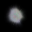

Loss: 0.668 (L1: 0.475, MSE: 0.337, SSIM: 0.950):  47%|██▊   | 2327/4929 [00:12<00:12, 203.64step/s]

JPG image saved to: results/step_02300.jpg


Loss: 0.667 (L1: 0.474, MSE: 0.336, SSIM: 0.949):  49%|██▉   | 2392/4929 [00:12<00:12, 201.97step/s]

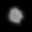

Loss: 0.667 (L1: 0.474, MSE: 0.336, SSIM: 0.949):  49%|██▉   | 2436/4929 [00:12<00:12, 202.83step/s]

JPG image saved to: results/step_02400.jpg


Loss: 0.666 (L1: 0.474, MSE: 0.336, SSIM: 0.948):  50%|███   | 2480/4929 [00:12<00:11, 209.32step/s]

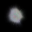

Loss: 0.666 (L1: 0.474, MSE: 0.336, SSIM: 0.947):  51%|███   | 2522/4929 [00:13<00:12, 199.33step/s]

JPG image saved to: results/step_02500.jpg


Loss: 0.666 (L1: 0.474, MSE: 0.336, SSIM: 0.946):  52%|███▏  | 2581/4929 [00:13<00:13, 175.92step/s]

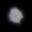

Loss: 0.665 (L1: 0.474, MSE: 0.336, SSIM: 0.946):  53%|███▏  | 2620/4929 [00:13<00:13, 173.88step/s]

JPG image saved to: results/step_02600.jpg


Loss: 0.665 (L1: 0.474, MSE: 0.336, SSIM: 0.945):  55%|███▎  | 2690/4929 [00:14<00:13, 161.65step/s]

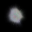

Loss: 0.664 (L1: 0.474, MSE: 0.336, SSIM: 0.944):  55%|███▎  | 2725/4929 [00:14<00:13, 166.75step/s]

JPG image saved to: results/step_02700.jpg


Loss: 0.664 (L1: 0.474, MSE: 0.336, SSIM: 0.943):  57%|███▍  | 2793/4929 [00:14<00:13, 162.10step/s]

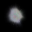

Loss: 0.664 (L1: 0.473, MSE: 0.335, SSIM: 0.943):  57%|███▍  | 2827/4929 [00:14<00:13, 159.32step/s]

JPG image saved to: results/step_02800.jpg


Loss: 0.663 (L1: 0.473, MSE: 0.335, SSIM: 0.942):  59%|███▌  | 2897/4929 [00:15<00:12, 167.07step/s]

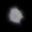

Loss: 0.663 (L1: 0.473, MSE: 0.335, SSIM: 0.941):  59%|███▌  | 2931/4929 [00:15<00:12, 161.28step/s]

JPG image saved to: results/step_02900.jpg


Loss: 0.662 (L1: 0.473, MSE: 0.335, SSIM: 0.940):  61%|███▋  | 2984/4929 [00:15<00:11, 167.05step/s]

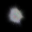

Loss: 0.662 (L1: 0.473, MSE: 0.335, SSIM: 0.940):  61%|███▋  | 3021/4929 [00:16<00:11, 172.68step/s]

JPG image saved to: results/step_03000.jpg


Loss: 0.661 (L1: 0.473, MSE: 0.335, SSIM: 0.939):  63%|███▊  | 3093/4929 [00:16<00:10, 174.10step/s]

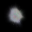

Loss: 0.661 (L1: 0.473, MSE: 0.335, SSIM: 0.939):  63%|███▊  | 3128/4929 [00:16<00:11, 163.58step/s]

JPG image saved to: results/step_03100.jpg


Loss: 0.661 (L1: 0.473, MSE: 0.335, SSIM: 0.938):  65%|███▉  | 3200/4929 [00:17<00:09, 174.61step/s]

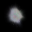

Loss: 0.660 (L1: 0.473, MSE: 0.334, SSIM: 0.937):  66%|███▉  | 3241/4929 [00:17<00:08, 189.85step/s]

JPG image saved to: results/step_03200.jpg


Loss: 0.660 (L1: 0.472, MSE: 0.334, SSIM: 0.936):  67%|███▉  | 3285/4929 [00:17<00:08, 201.00step/s]

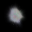

Loss: 0.659 (L1: 0.472, MSE: 0.334, SSIM: 0.936):  67%|████  | 3327/4929 [00:17<00:07, 202.59step/s]

JPG image saved to: results/step_03300.jpg


Loss: 0.659 (L1: 0.472, MSE: 0.334, SSIM: 0.935):  69%|████▏ | 3391/4929 [00:18<00:07, 205.69step/s]

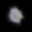

Loss: 0.659 (L1: 0.472, MSE: 0.334, SSIM: 0.934):  70%|████▏ | 3433/4929 [00:18<00:07, 196.40step/s]

JPG image saved to: results/step_03400.jpg


Loss: 0.658 (L1: 0.472, MSE: 0.334, SSIM: 0.933):  71%|████▏ | 3485/4929 [00:18<00:06, 229.52step/s]

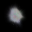

Loss: 0.658 (L1: 0.472, MSE: 0.334, SSIM: 0.933):  72%|████▎ | 3544/4929 [00:18<00:05, 261.48step/s]

JPG image saved to: results/step_03500.jpg


Loss: 0.657 (L1: 0.472, MSE: 0.334, SSIM: 0.932):  73%|████▎ | 3574/4929 [00:18<00:04, 272.77step/s]

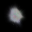

Loss: 0.657 (L1: 0.472, MSE: 0.333, SSIM: 0.931):  74%|████▍ | 3632/4929 [00:19<00:04, 277.78step/s]

JPG image saved to: results/step_03600.jpg


Loss: 0.657 (L1: 0.471, MSE: 0.333, SSIM: 0.931):  75%|████▍ | 3688/4929 [00:19<00:04, 265.79step/s]

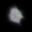

Loss: 0.656 (L1: 0.471, MSE: 0.333, SSIM: 0.930):  76%|████▌ | 3745/4929 [00:19<00:04, 266.76step/s]

JPG image saved to: results/step_03700.jpg


Loss: 0.656 (L1: 0.471, MSE: 0.333, SSIM: 0.929):  77%|████▌ | 3775/4929 [00:19<00:04, 275.64step/s]

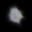

Loss: 0.655 (L1: 0.471, MSE: 0.333, SSIM: 0.929):  78%|████▋ | 3834/4929 [00:19<00:03, 283.11step/s]

JPG image saved to: results/step_03800.jpg


Loss: 0.655 (L1: 0.471, MSE: 0.333, SSIM: 0.928):  79%|████▋ | 3890/4929 [00:20<00:04, 229.22step/s]

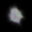

Loss: 0.655 (L1: 0.471, MSE: 0.333, SSIM: 0.928):  79%|████▊ | 3914/4929 [00:20<00:05, 201.38step/s]

JPG image saved to: results/step_03900.jpg


Loss: 0.654 (L1: 0.471, MSE: 0.333, SSIM: 0.927):  81%|████▊ | 3999/4929 [00:20<00:04, 200.11step/s]

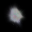

Loss: 0.654 (L1: 0.471, MSE: 0.333, SSIM: 0.926):  82%|████▉ | 4041/4929 [00:20<00:04, 199.90step/s]

JPG image saved to: results/step_04000.jpg


Loss: 0.654 (L1: 0.470, MSE: 0.332, SSIM: 0.926):  83%|████▉ | 4084/4929 [00:21<00:04, 204.98step/s]

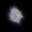

Loss: 0.653 (L1: 0.470, MSE: 0.332, SSIM: 0.925):  84%|█████ | 4125/4929 [00:21<00:04, 188.66step/s]

JPG image saved to: results/step_04100.jpg


Loss: 0.653 (L1: 0.470, MSE: 0.332, SSIM: 0.925):  85%|█████ | 4181/4929 [00:21<00:04, 171.78step/s]

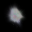

Loss: 0.653 (L1: 0.470, MSE: 0.332, SSIM: 0.924):  86%|█████▏| 4219/4929 [00:21<00:04, 175.61step/s]

JPG image saved to: results/step_04200.jpg


Loss: 0.652 (L1: 0.470, MSE: 0.332, SSIM: 0.923):  87%|█████▏| 4290/4929 [00:22<00:03, 170.94step/s]

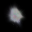

Loss: 0.652 (L1: 0.470, MSE: 0.332, SSIM: 0.923):  88%|█████▎| 4328/4929 [00:22<00:03, 175.97step/s]

JPG image saved to: results/step_04300.jpg


Loss: 0.651 (L1: 0.470, MSE: 0.332, SSIM: 0.922):  89%|█████▎| 4384/4929 [00:22<00:03, 178.02step/s]

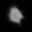

Loss: 0.651 (L1: 0.470, MSE: 0.331, SSIM: 0.922):  90%|█████▍| 4420/4929 [00:23<00:03, 169.31step/s]

JPG image saved to: results/step_04400.jpg


Loss: 0.651 (L1: 0.469, MSE: 0.331, SSIM: 0.921):  91%|█████▍| 4490/4929 [00:23<00:02, 170.75step/s]

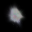

Loss: 0.651 (L1: 0.469, MSE: 0.331, SSIM: 0.921):  92%|█████▌| 4527/4929 [00:23<00:02, 175.01step/s]

JPG image saved to: results/step_04500.jpg


Loss: 0.650 (L1: 0.469, MSE: 0.331, SSIM: 0.920):  93%|█████▌| 4586/4929 [00:24<00:01, 182.31step/s]

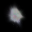

Loss: 0.650 (L1: 0.469, MSE: 0.331, SSIM: 0.920):  94%|█████▋| 4628/4929 [00:24<00:01, 195.99step/s]

JPG image saved to: results/step_04600.jpg


Loss: 0.649 (L1: 0.469, MSE: 0.331, SSIM: 0.919):  95%|█████▋| 4694/4929 [00:24<00:01, 209.72step/s]

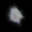

Loss: 0.649 (L1: 0.469, MSE: 0.331, SSIM: 0.918):  96%|█████▊| 4737/4929 [00:24<00:00, 210.79step/s]

JPG image saved to: results/step_04700.jpg


Loss: 0.649 (L1: 0.469, MSE: 0.331, SSIM: 0.918):  97%|█████▊| 4781/4929 [00:24<00:00, 212.84step/s]

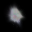

Loss: 0.648 (L1: 0.469, MSE: 0.330, SSIM: 0.917):  98%|█████▊| 4825/4929 [00:25<00:00, 212.44step/s]

JPG image saved to: results/step_04800.jpg


Loss: 0.648 (L1: 0.468, MSE: 0.330, SSIM: 0.917):  99%|█████▉| 4871/4929 [00:25<00:00, 208.47step/s]

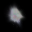

Loss: 0.648 (L1: 0.468, MSE: 0.330, SSIM: 0.916): 100%|██████| 4929/4929 [00:25<00:00, 193.44step/s]


JPG image saved to: results/step_04900.jpg
GIF saved to: results/animation.gif


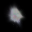

[I 2025-01-06 06:10:28,333] Trial 0 finished with value: 0.4682217836380005 and parameters: {'loss_weight_l1': 0.31320743567265075, 'loss_weight_mse': 0.5539792670233178, 'loss_weight_ssim': 0.8646538403632547, 'scale_regulation': 0.5, 'opacity_regulation': 1.0, 'init_type': 'random', 'num_points': 576, 'extent': 2.0, 'init_scale': 1.4963908337936989, 'init_opacity': 0.10716465888136174, 'max_steps': 4929, 'learning_rate': 1.6513587055956062e-05, 'model_type': '2dgs', 'bilateral_grid': False}. Best is trial 0 with value: 0.4682217836380005.


JPG image saved to: results/final.jpg
Final loss: 0.6477999091148376
Total Time: Rasterization: 3.659s, Backward: 10.570s
Trial 0 finished with value: 0.4682217836380005 and parameters: {'loss_weight_l1': 0.31320743567265075, 'loss_weight_mse': 0.5539792670233178, 'loss_weight_ssim': 0.8646538403632547, 'scale_regulation': 0.5, 'opacity_regulation': 1.0, 'init_type': 'random', 'num_points': 576, 'extent': 2.0, 'init_scale': 1.4963908337936989, 'init_opacity': 0.10716465888136174, 'max_steps': 4929, 'learning_rate': 1.6513587055956062e-05, 'model_type': '2dgs', 'bilateral_grid': False}. Best is trial 0 with value: 0.4682217836380005.
Trial 0 finished with value: 0.4682217836380005 and parameters: {'loss_weight_l1': 0.31320743567265075, 'loss_weight_mse': 0.5539792670233178, 'loss_weight_ssim': 0.8646538403632547, 'scale_regulation': 0.5, 'opacity_regulation': 1.0, 'init_type': 'random', 'num_points': 576, 'extent': 2.0, 'init_scale': 1.4963908337936989, 'init_opacity': 0.107164658881361

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/functional/image/lpips.py:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

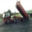

JPG image saved to: results/original.jpg


Loss: 0.585 (L1: 0.441, MSE: 0.283, SSIM: 1.083):   0%|                   | 0/944 [00:00<?, ?step/s]

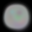

Loss: 0.572 (L1: 0.428, MSE: 0.270, SSIM: 1.070):   2%|▏        | 18/944 [00:00<00:05, 174.18step/s]

JPG image saved to: results/step_00000.jpg


Loss: 0.550 (L1: 0.405, MSE: 0.247, SSIM: 1.050):  10%|▉        | 98/944 [00:00<00:04, 190.68step/s]

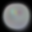

Loss: 0.526 (L1: 0.384, MSE: 0.227, SSIM: 1.019):  15%|█▏      | 141/944 [00:00<00:03, 202.38step/s]

JPG image saved to: results/step_00100.jpg


Loss: 0.495 (L1: 0.354, MSE: 0.197, SSIM: 0.984):  19%|█▌      | 183/944 [00:01<00:03, 197.87step/s]

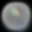

Loss: 0.473 (L1: 0.334, MSE: 0.177, SSIM: 0.953):  24%|█▉      | 222/944 [00:01<00:03, 187.09step/s]

JPG image saved to: results/step_00200.jpg


Loss: 0.431 (L1: 0.298, MSE: 0.140, SSIM: 0.895):  32%|██▌     | 299/944 [00:01<00:03, 187.53step/s]

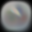

Loss: 0.406 (L1: 0.278, MSE: 0.120, SSIM: 0.856):  34%|██▋     | 318/944 [00:01<00:03, 187.73step/s]

JPG image saved to: results/step_00300.jpg


Loss: 0.362 (L1: 0.241, MSE: 0.086, SSIM: 0.791):  42%|███▎    | 395/944 [00:02<00:02, 185.56step/s]

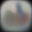

Loss: 0.335 (L1: 0.223, MSE: 0.071, SSIM: 0.737):  46%|███▋    | 435/944 [00:02<00:02, 191.45step/s]

JPG image saved to: results/step_00400.jpg


Loss: 0.287 (L1: 0.192, MSE: 0.050, SSIM: 0.632):  52%|████▏   | 493/944 [00:02<00:02, 182.51step/s]

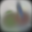

Loss: 0.265 (L1: 0.179, MSE: 0.042, SSIM: 0.583):  56%|████▌   | 531/944 [00:02<00:02, 180.68step/s]

JPG image saved to: results/step_00500.jpg


Loss: 0.230 (L1: 0.156, MSE: 0.031, SSIM: 0.505):  62%|████▉   | 588/944 [00:03<00:01, 182.68step/s]

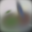

Loss: 0.212 (L1: 0.145, MSE: 0.027, SSIM: 0.468):  67%|█████▍  | 635/944 [00:03<00:01, 206.17step/s]

JPG image saved to: results/step_00600.jpg


Loss: 0.192 (L1: 0.132, MSE: 0.023, SSIM: 0.423):  72%|█████▊  | 683/944 [00:03<00:01, 219.75step/s]

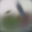

Loss: 0.181 (L1: 0.124, MSE: 0.020, SSIM: 0.398):  77%|██████▏ | 729/944 [00:03<00:00, 223.72step/s]

JPG image saved to: results/step_00700.jpg


Loss: 0.174 (L1: 0.121, MSE: 0.020, SSIM: 0.380):  85%|██████▊ | 800/944 [00:04<00:00, 228.83step/s]

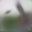

Loss: 0.167 (L1: 0.116, MSE: 0.019, SSIM: 0.364):  87%|██████▉ | 823/944 [00:04<00:00, 223.86step/s]

JPG image saved to: results/step_00800.jpg


Loss: 0.163 (L1: 0.112, MSE: 0.017, SSIM: 0.357):  94%|███████▌| 892/944 [00:04<00:00, 212.63step/s]

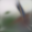

Loss: 0.158 (L1: 0.108, MSE: 0.017, SSIM: 0.349): 100%|████████| 944/944 [00:04<00:00, 199.73step/s]


JPG image saved to: results/step_00900.jpg
GIF saved to: results/animation.gif


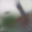

[I 2025-01-06 06:10:34,239] Trial 1 finished with value: 0.10806117206811905 and parameters: {'loss_weight_l1': 0.8792750902433263, 'loss_weight_mse': 0.1773429447087944, 'loss_weight_ssim': 0.3618847897862979, 'scale_regulation': 0.5, 'opacity_regulation': 1.0, 'init_type': 'knn', 'num_points': 1024, 'extent': 2.0, 'init_scale': 1.1466352193045959, 'init_opacity': 0.7835192836462006, 'max_steps': 944, 'learning_rate': 0.0007992505573535983, 'model_type': '3dgs', 'bilateral_grid': False}. Best is trial 1 with value: 0.10806117206811905.


JPG image saved to: results/final.jpg
Final loss: 0.15820667147636414
Total Time: Rasterization: 0.506s, Backward: 1.874s
Trial 1 finished with value: 0.10806117206811905 and parameters: {'loss_weight_l1': 0.8792750902433263, 'loss_weight_mse': 0.1773429447087944, 'loss_weight_ssim': 0.3618847897862979, 'scale_regulation': 0.5, 'opacity_regulation': 1.0, 'init_type': 'knn', 'num_points': 1024, 'extent': 2.0, 'init_scale': 1.1466352193045959, 'init_opacity': 0.7835192836462006, 'max_steps': 944, 'learning_rate': 0.0007992505573535983, 'model_type': '3dgs', 'bilateral_grid': False}. Best is trial 1 with value: 0.10806117206811905.
Trial 1 finished with value: 0.10806117206811905 and parameters: {'loss_weight_l1': 0.8792750902433263, 'loss_weight_mse': 0.1773429447087944, 'loss_weight_ssim': 0.3618847897862979, 'scale_regulation': 0.5, 'opacity_regulation': 1.0, 'init_type': 'knn', 'num_points': 1024, 'extent': 2.0, 'init_scale': 1.1466352193045959, 'init_opacity': 0.7835192836462006, 'ma

[I 2025-01-06 06:10:34,499] Trial 2 pruned. Invalid hyperparameter combination


Trial 2 pruned. Invalid hyperparameter combination
Trial 2 pruned. Invalid hyperparameter combination
Trial 2 pruned. Invalid hyperparameter combination
Trial 2 pruned. Invalid hyperparameter combination
Model initialized. Number of Gaussians: 256


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/functional/image/lpips.py:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

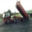

JPG image saved to: results/original.jpg


Loss: 0.642 (L1: 0.496, MSE: 0.357, SSIM: 0.973):   0%|                  | 0/6391 [00:00<?, ?step/s]

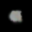

Loss: 0.642 (L1: 0.496, MSE: 0.357, SSIM: 0.972):   0%|        | 20/6391 [00:00<00:33, 192.26step/s]

JPG image saved to: results/step_00000.jpg


Loss: 0.641 (L1: 0.495, MSE: 0.357, SSIM: 0.971):   1%|        | 84/6391 [00:00<00:30, 204.60step/s]

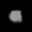

Loss: 0.641 (L1: 0.495, MSE: 0.357, SSIM: 0.970):   2%|▏      | 129/6391 [00:00<00:29, 213.14step/s]

JPG image saved to: results/step_00100.jpg


Loss: 0.640 (L1: 0.495, MSE: 0.357, SSIM: 0.969):   3%|▏      | 192/6391 [00:01<00:31, 196.07step/s]

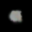

Loss: 0.640 (L1: 0.495, MSE: 0.357, SSIM: 0.969):   4%|▎      | 231/6391 [00:01<00:33, 185.87step/s]

JPG image saved to: results/step_00200.jpg


Loss: 0.640 (L1: 0.495, MSE: 0.357, SSIM: 0.968):   5%|▎      | 288/6391 [00:01<00:33, 184.08step/s]

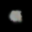

Loss: 0.639 (L1: 0.495, MSE: 0.356, SSIM: 0.967):   5%|▎      | 326/6391 [00:01<00:33, 181.25step/s]

JPG image saved to: results/step_00300.jpg


Loss: 0.639 (L1: 0.494, MSE: 0.356, SSIM: 0.966):   6%|▍      | 383/6391 [00:02<00:33, 180.78step/s]

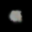

Loss: 0.638 (L1: 0.494, MSE: 0.356, SSIM: 0.965):   7%|▍      | 420/6391 [00:02<00:33, 177.77step/s]

JPG image saved to: results/step_00400.jpg


Loss: 0.638 (L1: 0.494, MSE: 0.356, SSIM: 0.964):   8%|▌      | 482/6391 [00:02<00:31, 190.41step/s]

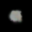

Loss: 0.638 (L1: 0.494, MSE: 0.356, SSIM: 0.964):   8%|▌      | 522/6391 [00:02<00:31, 185.91step/s]

JPG image saved to: results/step_00500.jpg


Loss: 0.637 (L1: 0.494, MSE: 0.356, SSIM: 0.963):   9%|▋      | 584/6391 [00:03<00:30, 188.54step/s]

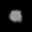

Loss: 0.637 (L1: 0.493, MSE: 0.355, SSIM: 0.962):  10%|▋      | 622/6391 [00:03<00:31, 184.67step/s]

JPG image saved to: results/step_00600.jpg


Loss: 0.636 (L1: 0.493, MSE: 0.355, SSIM: 0.961):  11%|▊      | 694/6391 [00:03<00:26, 218.10step/s]

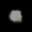

Loss: 0.636 (L1: 0.493, MSE: 0.355, SSIM: 0.960):  12%|▊      | 741/6391 [00:03<00:25, 224.83step/s]

JPG image saved to: results/step_00700.jpg


Loss: 0.635 (L1: 0.493, MSE: 0.355, SSIM: 0.959):  12%|▊      | 791/6391 [00:04<00:23, 233.73step/s]

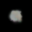

Loss: 0.635 (L1: 0.493, MSE: 0.355, SSIM: 0.958):  13%|▉      | 840/6391 [00:04<00:23, 236.35step/s]

JPG image saved to: results/step_00800.jpg


Loss: 0.634 (L1: 0.492, MSE: 0.355, SSIM: 0.957):  14%|▉      | 889/6391 [00:04<00:23, 236.88step/s]

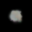

Loss: 0.634 (L1: 0.492, MSE: 0.355, SSIM: 0.957):  15%|█      | 936/6391 [00:04<00:24, 219.28step/s]

JPG image saved to: results/step_00900.jpg


Loss: 0.633 (L1: 0.492, MSE: 0.354, SSIM: 0.956):  16%|█      | 991/6391 [00:04<00:22, 244.30step/s]

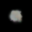

Loss: 0.633 (L1: 0.492, MSE: 0.354, SSIM: 0.955):  16%|▉     | 1041/6391 [00:05<00:22, 236.47step/s]

JPG image saved to: results/step_01000.jpg


Loss: 0.632 (L1: 0.492, MSE: 0.354, SSIM: 0.954):  17%|█     | 1094/6391 [00:05<00:21, 250.54step/s]

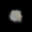

Loss: 0.632 (L1: 0.491, MSE: 0.354, SSIM: 0.953):  18%|█     | 1145/6391 [00:05<00:22, 237.02step/s]

JPG image saved to: results/step_01100.jpg


Loss: 0.632 (L1: 0.491, MSE: 0.354, SSIM: 0.952):  19%|█     | 1196/6391 [00:05<00:21, 241.04step/s]

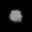

Loss: 0.631 (L1: 0.491, MSE: 0.354, SSIM: 0.952):  19%|█▏    | 1221/6391 [00:05<00:21, 239.14step/s]

JPG image saved to: results/step_01200.jpg


Loss: 0.631 (L1: 0.491, MSE: 0.353, SSIM: 0.951):  20%|█▏    | 1293/6391 [00:06<00:22, 225.07step/s]

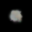

Loss: 0.630 (L1: 0.491, MSE: 0.353, SSIM: 0.950):  21%|█▎    | 1338/6391 [00:06<00:24, 204.78step/s]

JPG image saved to: results/step_01300.jpg


Loss: 0.630 (L1: 0.490, MSE: 0.353, SSIM: 0.949):  22%|█▎    | 1400/6391 [00:06<00:25, 196.90step/s]

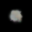

Loss: 0.629 (L1: 0.490, MSE: 0.353, SSIM: 0.948):  22%|█▎    | 1420/6391 [00:06<00:25, 191.27step/s]

JPG image saved to: results/step_01400.jpg


Loss: 0.629 (L1: 0.490, MSE: 0.353, SSIM: 0.947):  23%|█▍    | 1480/6391 [00:07<00:25, 192.22step/s]

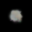

Loss: 0.629 (L1: 0.490, MSE: 0.353, SSIM: 0.947):  24%|█▍    | 1521/6391 [00:07<00:24, 196.61step/s]

JPG image saved to: results/step_01500.jpg


Loss: 0.628 (L1: 0.490, MSE: 0.352, SSIM: 0.946):  25%|█▌    | 1599/6391 [00:07<00:26, 184.20step/s]

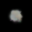

Loss: 0.628 (L1: 0.489, MSE: 0.352, SSIM: 0.945):  26%|█▌    | 1638/6391 [00:07<00:25, 183.77step/s]

JPG image saved to: results/step_01600.jpg


Loss: 0.627 (L1: 0.489, MSE: 0.352, SSIM: 0.944):  27%|█▌    | 1696/6391 [00:08<00:25, 186.84step/s]

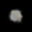

Loss: 0.627 (L1: 0.489, MSE: 0.352, SSIM: 0.943):  27%|█▋    | 1735/6391 [00:08<00:24, 188.94step/s]

JPG image saved to: results/step_01700.jpg


Loss: 0.626 (L1: 0.489, MSE: 0.352, SSIM: 0.942):  28%|█▋    | 1792/6391 [00:08<00:24, 187.42step/s]

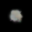

Loss: 0.626 (L1: 0.489, MSE: 0.352, SSIM: 0.942):  29%|█▋    | 1831/6391 [00:09<00:24, 185.23step/s]

JPG image saved to: results/step_01800.jpg


Loss: 0.625 (L1: 0.488, MSE: 0.351, SSIM: 0.941):  30%|█▊    | 1897/6391 [00:09<00:21, 207.92step/s]

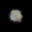

Loss: 0.625 (L1: 0.488, MSE: 0.351, SSIM: 0.940):  30%|█▊    | 1939/6391 [00:09<00:22, 199.52step/s]

JPG image saved to: results/step_01900.jpg


Loss: 0.624 (L1: 0.488, MSE: 0.351, SSIM: 0.939):  31%|█▊    | 1983/6391 [00:09<00:22, 199.96step/s]

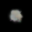

Loss: 0.624 (L1: 0.488, MSE: 0.351, SSIM: 0.938):  32%|█▉    | 2030/6391 [00:10<00:20, 213.60step/s]

JPG image saved to: results/step_02000.jpg


Loss: 0.623 (L1: 0.487, MSE: 0.351, SSIM: 0.938):  32%|█▉    | 2077/6391 [00:10<00:19, 219.33step/s]

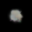

Loss: 0.623 (L1: 0.487, MSE: 0.351, SSIM: 0.937):  33%|█▉    | 2125/6391 [00:10<00:19, 224.21step/s]

JPG image saved to: results/step_02100.jpg


Loss: 0.623 (L1: 0.487, MSE: 0.350, SSIM: 0.936):  34%|██    | 2197/6391 [00:10<00:18, 231.54step/s]

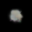

Loss: 0.622 (L1: 0.487, MSE: 0.350, SSIM: 0.935):  35%|██    | 2250/6391 [00:10<00:16, 245.40step/s]

JPG image saved to: results/step_02200.jpg


Loss: 0.622 (L1: 0.486, MSE: 0.350, SSIM: 0.934):  36%|██▏   | 2299/6391 [00:11<00:18, 226.68step/s]

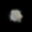

Loss: 0.621 (L1: 0.486, MSE: 0.350, SSIM: 0.934):  36%|██▏   | 2322/6391 [00:11<00:18, 219.12step/s]

JPG image saved to: results/step_02300.jpg


Loss: 0.621 (L1: 0.486, MSE: 0.350, SSIM: 0.933):  37%|██▏   | 2392/6391 [00:11<00:17, 225.11step/s]

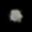

Loss: 0.620 (L1: 0.486, MSE: 0.349, SSIM: 0.932):  38%|██▎   | 2445/6391 [00:11<00:16, 243.49step/s]

JPG image saved to: results/step_02400.jpg


Loss: 0.620 (L1: 0.485, MSE: 0.349, SSIM: 0.931):  39%|██▎   | 2494/6391 [00:12<00:17, 226.81step/s]

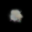

Loss: 0.620 (L1: 0.485, MSE: 0.349, SSIM: 0.931):  40%|██▍   | 2546/6391 [00:12<00:16, 237.44step/s]

JPG image saved to: results/step_02500.jpg


Loss: 0.619 (L1: 0.485, MSE: 0.349, SSIM: 0.930):  41%|██▍   | 2597/6391 [00:12<00:15, 241.30step/s]

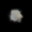

Loss: 0.619 (L1: 0.485, MSE: 0.349, SSIM: 0.929):  41%|██▍   | 2623/6391 [00:12<00:15, 246.42step/s]

JPG image saved to: results/step_02600.jpg


Loss: 0.618 (L1: 0.484, MSE: 0.349, SSIM: 0.928):  42%|██▌   | 2696/6391 [00:12<00:16, 226.71step/s]

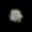

Loss: 0.618 (L1: 0.484, MSE: 0.348, SSIM: 0.928):  43%|██▌   | 2719/6391 [00:13<00:17, 211.09step/s]

JPG image saved to: results/step_02700.jpg


Loss: 0.617 (L1: 0.484, MSE: 0.348, SSIM: 0.927):  44%|██▌   | 2786/6391 [00:13<00:17, 206.50step/s]

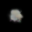

Loss: 0.617 (L1: 0.484, MSE: 0.348, SSIM: 0.926):  44%|██▋   | 2827/6391 [00:13<00:18, 196.20step/s]

JPG image saved to: results/step_02800.jpg


Loss: 0.617 (L1: 0.483, MSE: 0.348, SSIM: 0.925):  45%|██▋   | 2886/6391 [00:13<00:19, 183.67step/s]

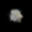

Loss: 0.616 (L1: 0.483, MSE: 0.348, SSIM: 0.925):  46%|██▋   | 2926/6391 [00:14<00:18, 189.69step/s]

JPG image saved to: results/step_02900.jpg


Loss: 0.616 (L1: 0.483, MSE: 0.347, SSIM: 0.924):  47%|██▊   | 2985/6391 [00:14<00:18, 187.27step/s]

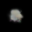

Loss: 0.615 (L1: 0.483, MSE: 0.347, SSIM: 0.923):  47%|██▊   | 3023/6391 [00:14<00:18, 185.51step/s]

JPG image saved to: results/step_03000.jpg


Loss: 0.615 (L1: 0.482, MSE: 0.347, SSIM: 0.922):  49%|██▉   | 3100/6391 [00:15<00:17, 184.83step/s]

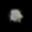

Loss: 0.614 (L1: 0.482, MSE: 0.347, SSIM: 0.922):  49%|██▉   | 3121/6391 [00:15<00:17, 190.14step/s]

JPG image saved to: results/step_03100.jpg


Loss: 0.614 (L1: 0.482, MSE: 0.347, SSIM: 0.921):  50%|██▉   | 3180/6391 [00:15<00:17, 188.30step/s]

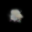

Loss: 0.614 (L1: 0.482, MSE: 0.347, SSIM: 0.921):  50%|███   | 3221/6391 [00:15<00:16, 188.52step/s]

JPG image saved to: results/step_03200.jpg


Loss: 0.613 (L1: 0.481, MSE: 0.346, SSIM: 0.920):  52%|███   | 3300/6391 [00:16<00:16, 185.77step/s]

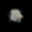

Loss: 0.613 (L1: 0.481, MSE: 0.346, SSIM: 0.919):  52%|███   | 3319/6391 [00:16<00:16, 182.16step/s]

JPG image saved to: results/step_03300.jpg


Loss: 0.612 (L1: 0.481, MSE: 0.346, SSIM: 0.918):  53%|███▏  | 3394/6391 [00:16<00:16, 178.24step/s]

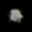

Loss: 0.612 (L1: 0.481, MSE: 0.346, SSIM: 0.918):  54%|███▏  | 3430/6391 [00:16<00:17, 172.24step/s]

JPG image saved to: results/step_03400.jpg


Loss: 0.612 (L1: 0.480, MSE: 0.346, SSIM: 0.917):  54%|███▎  | 3478/6391 [00:17<00:14, 203.15step/s]

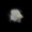

Loss: 0.611 (L1: 0.480, MSE: 0.346, SSIM: 0.916):  55%|███▎  | 3525/6391 [00:17<00:13, 216.56step/s]

JPG image saved to: results/step_03500.jpg


Loss: 0.611 (L1: 0.480, MSE: 0.345, SSIM: 0.915):  56%|███▍  | 3597/6391 [00:17<00:12, 227.74step/s]

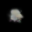

Loss: 0.610 (L1: 0.479, MSE: 0.345, SSIM: 0.915):  57%|███▍  | 3644/6391 [00:17<00:12, 227.59step/s]

JPG image saved to: results/step_03600.jpg


Loss: 0.610 (L1: 0.479, MSE: 0.345, SSIM: 0.914):  58%|███▍  | 3691/6391 [00:18<00:11, 228.92step/s]

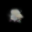

Loss: 0.610 (L1: 0.479, MSE: 0.345, SSIM: 0.914):  58%|███▌  | 3737/6391 [00:18<00:12, 215.07step/s]

JPG image saved to: results/step_03700.jpg


Loss: 0.609 (L1: 0.479, MSE: 0.345, SSIM: 0.913):  59%|███▌  | 3791/6391 [00:18<00:10, 239.52step/s]

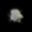

Loss: 0.609 (L1: 0.478, MSE: 0.344, SSIM: 0.912):  60%|███▌  | 3852/6391 [00:18<00:09, 271.90step/s]

JPG image saved to: results/step_03800.jpg


Loss: 0.608 (L1: 0.478, MSE: 0.344, SSIM: 0.911):  61%|███▋  | 3884/6391 [00:18<00:08, 284.69step/s]

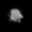

Loss: 0.608 (L1: 0.478, MSE: 0.344, SSIM: 0.911):  62%|███▋  | 3952/6391 [00:18<00:07, 310.96step/s]

JPG image saved to: results/step_03900.jpg


Loss: 0.608 (L1: 0.478, MSE: 0.344, SSIM: 0.910):  62%|███▋  | 3986/6391 [00:19<00:07, 319.26step/s]

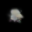

Loss: 0.607 (L1: 0.477, MSE: 0.344, SSIM: 0.909):  63%|███▊  | 4052/6391 [00:19<00:07, 320.31step/s]

JPG image saved to: results/step_04000.jpg


Loss: 0.607 (L1: 0.477, MSE: 0.344, SSIM: 0.909):  64%|███▊  | 4087/6391 [00:19<00:07, 327.70step/s]

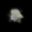

Loss: 0.606 (L1: 0.477, MSE: 0.343, SSIM: 0.908):  65%|███▉  | 4154/6391 [00:19<00:06, 326.78step/s]

JPG image saved to: results/step_04100.jpg


Loss: 0.606 (L1: 0.477, MSE: 0.343, SSIM: 0.908):  66%|███▉  | 4187/6391 [00:19<00:07, 310.06step/s]

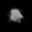

Loss: 0.606 (L1: 0.476, MSE: 0.343, SSIM: 0.907):  66%|███▉  | 4219/6391 [00:19<00:07, 284.41step/s]

JPG image saved to: results/step_04200.jpg


Loss: 0.605 (L1: 0.476, MSE: 0.343, SSIM: 0.906):  67%|████  | 4300/6391 [00:20<00:09, 230.47step/s]

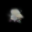

Loss: 0.605 (L1: 0.476, MSE: 0.343, SSIM: 0.906):  68%|████  | 4324/6391 [00:20<00:09, 213.95step/s]

JPG image saved to: results/step_04300.jpg


Loss: 0.604 (L1: 0.476, MSE: 0.342, SSIM: 0.905):  69%|████  | 4389/6391 [00:20<00:09, 205.97step/s]

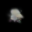

Loss: 0.604 (L1: 0.475, MSE: 0.342, SSIM: 0.905):  69%|████▏ | 4431/6391 [00:20<00:09, 203.09step/s]

JPG image saved to: results/step_04400.jpg


Loss: 0.604 (L1: 0.475, MSE: 0.342, SSIM: 0.904):  70%|████▏ | 4494/6391 [00:21<00:09, 195.85step/s]

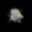

Loss: 0.604 (L1: 0.475, MSE: 0.342, SSIM: 0.904):  71%|████▎ | 4534/6391 [00:21<00:09, 188.74step/s]

JPG image saved to: results/step_04500.jpg


Loss: 0.603 (L1: 0.475, MSE: 0.342, SSIM: 0.903):  72%|████▎ | 4596/6391 [00:21<00:09, 196.34step/s]

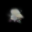

Loss: 0.603 (L1: 0.474, MSE: 0.342, SSIM: 0.902):  73%|████▎ | 4636/6391 [00:21<00:09, 191.05step/s]

JPG image saved to: results/step_04600.jpg


Loss: 0.602 (L1: 0.474, MSE: 0.341, SSIM: 0.902):  74%|████▍ | 4699/6391 [00:22<00:08, 200.44step/s]

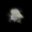

Loss: 0.602 (L1: 0.474, MSE: 0.341, SSIM: 0.901):  74%|████▍ | 4720/6391 [00:22<00:08, 192.37step/s]

JPG image saved to: results/step_04700.jpg


Loss: 0.602 (L1: 0.474, MSE: 0.341, SSIM: 0.900):  75%|████▍ | 4781/6391 [00:22<00:08, 194.90step/s]

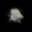

Loss: 0.601 (L1: 0.473, MSE: 0.341, SSIM: 0.900):  75%|████▌ | 4821/6391 [00:22<00:08, 191.73step/s]

JPG image saved to: results/step_04800.jpg


Loss: 0.601 (L1: 0.473, MSE: 0.341, SSIM: 0.899):  76%|████▌ | 4883/6391 [00:23<00:07, 197.00step/s]

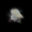

Loss: 0.601 (L1: 0.473, MSE: 0.341, SSIM: 0.899):  77%|████▌ | 4923/6391 [00:23<00:07, 192.72step/s]

JPG image saved to: results/step_04900.jpg


Loss: 0.600 (L1: 0.473, MSE: 0.340, SSIM: 0.898):  78%|████▋ | 4983/6391 [00:23<00:07, 185.34step/s]

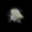

Loss: 0.600 (L1: 0.472, MSE: 0.340, SSIM: 0.898):  79%|████▋ | 5022/6391 [00:24<00:07, 185.91step/s]

JPG image saved to: results/step_05000.jpg


Loss: 0.600 (L1: 0.472, MSE: 0.340, SSIM: 0.897):  80%|████▊ | 5091/6391 [00:24<00:06, 213.01step/s]

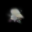

Loss: 0.599 (L1: 0.472, MSE: 0.340, SSIM: 0.897):  80%|████▊ | 5140/6391 [00:24<00:05, 225.37step/s]

JPG image saved to: results/step_05100.jpg


Loss: 0.599 (L1: 0.472, MSE: 0.340, SSIM: 0.896):  81%|████▊ | 5190/6391 [00:24<00:05, 233.56step/s]

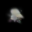

Loss: 0.598 (L1: 0.471, MSE: 0.340, SSIM: 0.895):  82%|████▉ | 5239/6391 [00:24<00:04, 234.52step/s]

JPG image saved to: results/step_05200.jpg


Loss: 0.598 (L1: 0.471, MSE: 0.339, SSIM: 0.895):  83%|████▉ | 5289/6391 [00:25<00:04, 238.26step/s]

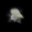

Loss: 0.598 (L1: 0.471, MSE: 0.339, SSIM: 0.894):  83%|█████ | 5336/6391 [00:25<00:04, 216.63step/s]

JPG image saved to: results/step_05300.jpg


Loss: 0.597 (L1: 0.471, MSE: 0.339, SSIM: 0.894):  84%|█████ | 5369/6391 [00:25<00:04, 247.62step/s]

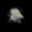

Loss: 0.597 (L1: 0.470, MSE: 0.339, SSIM: 0.893):  85%|█████ | 5430/6391 [00:25<00:03, 274.26step/s]

JPG image saved to: results/step_05400.jpg


Loss: 0.597 (L1: 0.470, MSE: 0.339, SSIM: 0.893):  86%|█████▏| 5487/6391 [00:25<00:03, 262.68step/s]

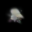

Loss: 0.596 (L1: 0.470, MSE: 0.338, SSIM: 0.892):  87%|█████▏| 5552/6391 [00:26<00:02, 290.59step/s]

JPG image saved to: results/step_05500.jpg


Loss: 0.596 (L1: 0.470, MSE: 0.338, SSIM: 0.892):  87%|█████▏| 5582/6391 [00:26<00:02, 284.31step/s]

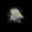

Loss: 0.596 (L1: 0.469, MSE: 0.338, SSIM: 0.891):  88%|█████▎| 5641/6391 [00:26<00:02, 274.48step/s]

JPG image saved to: results/step_05600.jpg


Loss: 0.595 (L1: 0.469, MSE: 0.338, SSIM: 0.891):  89%|█████▎| 5677/6391 [00:26<00:02, 298.58step/s]

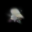

Loss: 0.595 (L1: 0.469, MSE: 0.338, SSIM: 0.890):  90%|█████▍| 5749/6391 [00:26<00:01, 326.94step/s]

JPG image saved to: results/step_05700.jpg


Loss: 0.595 (L1: 0.469, MSE: 0.338, SSIM: 0.890):  91%|█████▍| 5786/6391 [00:26<00:01, 336.81step/s]

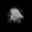

Loss: 0.594 (L1: 0.469, MSE: 0.337, SSIM: 0.889):  91%|█████▍| 5820/6391 [00:27<00:01, 306.65step/s]

JPG image saved to: results/step_05800.jpg


Loss: 0.594 (L1: 0.468, MSE: 0.337, SSIM: 0.889):  92%|█████▌| 5880/6391 [00:27<00:02, 239.70step/s]

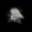

Loss: 0.594 (L1: 0.468, MSE: 0.337, SSIM: 0.888):  93%|█████▌| 5930/6391 [00:27<00:02, 213.04step/s]

JPG image saved to: results/step_05900.jpg


Loss: 0.593 (L1: 0.468, MSE: 0.337, SSIM: 0.888):  94%|█████▋| 5993/6391 [00:27<00:02, 183.87step/s]

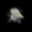

Loss: 0.593 (L1: 0.468, MSE: 0.337, SSIM: 0.887):  94%|█████▋| 6031/6391 [00:28<00:02, 176.56step/s]

JPG image saved to: results/step_06000.jpg


Loss: 0.593 (L1: 0.467, MSE: 0.337, SSIM: 0.887):  95%|█████▋| 6094/6391 [00:28<00:01, 196.77step/s]

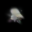

Loss: 0.593 (L1: 0.467, MSE: 0.336, SSIM: 0.886):  96%|█████▊| 6134/6391 [00:28<00:01, 190.50step/s]

JPG image saved to: results/step_06100.jpg


Loss: 0.592 (L1: 0.467, MSE: 0.336, SSIM: 0.886):  97%|█████▊| 6192/6391 [00:28<00:01, 186.34step/s]

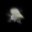

Loss: 0.592 (L1: 0.467, MSE: 0.336, SSIM: 0.885):  97%|█████▊| 6230/6391 [00:29<00:00, 180.51step/s]

JPG image saved to: results/step_06200.jpg


Loss: 0.592 (L1: 0.466, MSE: 0.336, SSIM: 0.885):  98%|█████▉| 6287/6391 [00:29<00:00, 182.66step/s]

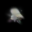

Loss: 0.591 (L1: 0.466, MSE: 0.336, SSIM: 0.884):  99%|█████▉| 6325/6391 [00:29<00:00, 181.95step/s]

JPG image saved to: results/step_06300.jpg


Loss: 0.591 (L1: 0.466, MSE: 0.336, SSIM: 0.884): 100%|██████| 6391/6391 [00:30<00:00, 212.77step/s]


GIF saved to: results/animation.gif


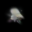

[I 2025-01-06 06:11:07,416] Trial 3 finished with value: 0.4659530818462372 and parameters: {'loss_weight_l1': 0.33473601873320463, 'loss_weight_mse': 0.5230217856753968, 'loss_weight_ssim': 0.5993126505129717, 'scale_regulation': 1.0, 'opacity_regulation': None, 'init_type': 'knn', 'num_points': 256, 'extent': 4.0, 'init_scale': 1.397326769805282, 'init_opacity': 0.2366185483348057, 'max_steps': 6391, 'learning_rate': 4.5562784341170444e-05, 'model_type': '3dgs', 'bilateral_grid': True}. Best is trial 1 with value: 0.10806117206811905.


JPG image saved to: results/final.jpg
Final loss: 0.5909951329231262
Total Time: Rasterization: 2.799s, Backward: 11.954s
Trial 3 finished with value: 0.4659530818462372 and parameters: {'loss_weight_l1': 0.33473601873320463, 'loss_weight_mse': 0.5230217856753968, 'loss_weight_ssim': 0.5993126505129717, 'scale_regulation': 1.0, 'opacity_regulation': None, 'init_type': 'knn', 'num_points': 256, 'extent': 4.0, 'init_scale': 1.397326769805282, 'init_opacity': 0.2366185483348057, 'max_steps': 6391, 'learning_rate': 4.5562784341170444e-05, 'model_type': '3dgs', 'bilateral_grid': True}. Best is trial 1 with value: 0.10806117206811905.
Trial 3 finished with value: 0.4659530818462372 and parameters: {'loss_weight_l1': 0.33473601873320463, 'loss_weight_mse': 0.5230217856753968, 'loss_weight_ssim': 0.5993126505129717, 'scale_regulation': 1.0, 'opacity_regulation': None, 'init_type': 'knn', 'num_points': 256, 'extent': 4.0, 'init_scale': 1.397326769805282, 'init_opacity': 0.2366185483348057, 'max

[I 2025-01-06 06:11:07,628] Trial 4 pruned. Invalid hyperparameter combination


Trial 4 pruned. Invalid hyperparameter combination
Trial 4 pruned. Invalid hyperparameter combination
Trial 4 pruned. Invalid hyperparameter combination
Trial 4 pruned. Invalid hyperparameter combination


[I 2025-01-06 06:11:07,832] Trial 5 pruned. Invalid hyperparameter combination


Trial 5 pruned. Invalid hyperparameter combination
Trial 5 pruned. Invalid hyperparameter combination
Trial 5 pruned. Invalid hyperparameter combination
Trial 5 pruned. Invalid hyperparameter combination


[I 2025-01-06 06:11:08,027] Trial 6 pruned. Invalid hyperparameter combination


Trial 6 pruned. Invalid hyperparameter combination
Trial 6 pruned. Invalid hyperparameter combination
Trial 6 pruned. Invalid hyperparameter combination
Trial 6 pruned. Invalid hyperparameter combination
Model initialized. Number of Gaussians: 256


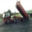

JPG image saved to: results/original.jpg


Loss: 0.659 (L1: 0.512, MSE: 0.371, SSIM: 1.000):   0%|                  | 0/8473 [00:00<?, ?step/s]

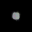

Loss: 0.659 (L1: 0.512, MSE: 0.370, SSIM: 1.000):   0%|        | 20/8473 [00:00<00:42, 199.28step/s]

JPG image saved to: results/step_00000.jpg


Loss: 0.659 (L1: 0.511, MSE: 0.370, SSIM: 1.000):   1%|       | 100/8473 [00:00<00:43, 194.54step/s]

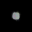

Loss: 0.658 (L1: 0.511, MSE: 0.370, SSIM: 0.999):   1%|       | 120/8473 [00:00<00:44, 186.65step/s]

JPG image saved to: results/step_00100.jpg


Loss: 0.658 (L1: 0.511, MSE: 0.370, SSIM: 0.999):   2%|▏      | 193/8473 [00:01<00:48, 171.35step/s]

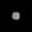

Loss: 0.658 (L1: 0.511, MSE: 0.370, SSIM: 0.999):   3%|▏      | 228/8473 [00:01<00:48, 168.61step/s]

JPG image saved to: results/step_00200.jpg


Loss: 0.658 (L1: 0.511, MSE: 0.370, SSIM: 0.998):   4%|▏      | 300/8473 [00:01<00:48, 169.87step/s]

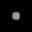

Loss: 0.658 (L1: 0.511, MSE: 0.370, SSIM: 0.998):   4%|▎      | 339/8473 [00:01<00:44, 181.94step/s]

JPG image saved to: results/step_00300.jpg


Loss: 0.657 (L1: 0.511, MSE: 0.370, SSIM: 0.998):   5%|▎      | 394/8473 [00:02<00:46, 174.93step/s]

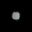

Loss: 0.657 (L1: 0.511, MSE: 0.370, SSIM: 0.997):   5%|▎      | 430/8473 [00:02<00:46, 172.92step/s]

JPG image saved to: results/step_00400.jpg


Loss: 0.657 (L1: 0.510, MSE: 0.370, SSIM: 0.997):   6%|▍      | 484/8473 [00:02<00:45, 174.03step/s]

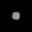

Loss: 0.657 (L1: 0.510, MSE: 0.370, SSIM: 0.997):   6%|▍      | 520/8473 [00:03<00:46, 170.46step/s]

JPG image saved to: results/step_00500.jpg


Loss: 0.657 (L1: 0.510, MSE: 0.369, SSIM: 0.996):   7%|▍      | 599/8473 [00:03<00:40, 192.26step/s]

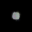

Loss: 0.657 (L1: 0.510, MSE: 0.369, SSIM: 0.996):   8%|▌      | 641/8473 [00:03<00:38, 201.39step/s]

JPG image saved to: results/step_00600.jpg


Loss: 0.656 (L1: 0.510, MSE: 0.369, SSIM: 0.996):   8%|▌      | 686/8473 [00:03<00:36, 210.81step/s]

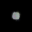

Loss: 0.656 (L1: 0.510, MSE: 0.369, SSIM: 0.996):   9%|▌      | 731/8473 [00:04<00:36, 213.34step/s]

JPG image saved to: results/step_00700.jpg


Loss: 0.656 (L1: 0.510, MSE: 0.369, SSIM: 0.995):   9%|▋      | 800/8473 [00:04<00:34, 220.23step/s]

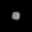

Loss: 0.656 (L1: 0.510, MSE: 0.369, SSIM: 0.995):  10%|▋      | 823/8473 [00:04<00:35, 215.10step/s]

JPG image saved to: results/step_00800.jpg


Loss: 0.656 (L1: 0.510, MSE: 0.369, SSIM: 0.995):  11%|▋      | 894/8473 [00:04<00:34, 221.39step/s]

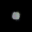

Loss: 0.655 (L1: 0.509, MSE: 0.369, SSIM: 0.994):  11%|▊      | 943/8473 [00:04<00:32, 230.64step/s]

JPG image saved to: results/step_00900.jpg


Loss: 0.655 (L1: 0.509, MSE: 0.369, SSIM: 0.994):  12%|▊      | 993/8473 [00:05<00:32, 233.43step/s]

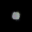

Loss: 0.655 (L1: 0.509, MSE: 0.369, SSIM: 0.994):  12%|▋     | 1040/8473 [00:05<00:34, 214.17step/s]

JPG image saved to: results/step_01000.jpg


Loss: 0.655 (L1: 0.509, MSE: 0.368, SSIM: 0.993):  13%|▊     | 1083/8473 [00:05<00:36, 203.31step/s]

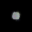

Loss: 0.655 (L1: 0.509, MSE: 0.368, SSIM: 0.993):  13%|▊     | 1125/8473 [00:05<00:36, 200.10step/s]

JPG image saved to: results/step_01100.jpg


Loss: 0.654 (L1: 0.509, MSE: 0.368, SSIM: 0.993):  14%|▊     | 1188/8473 [00:06<00:36, 200.90step/s]

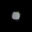

Loss: 0.654 (L1: 0.509, MSE: 0.368, SSIM: 0.993):  15%|▊     | 1229/8473 [00:06<00:37, 194.42step/s]

JPG image saved to: results/step_01200.jpg


Loss: 0.654 (L1: 0.509, MSE: 0.368, SSIM: 0.992):  15%|▉     | 1289/8473 [00:06<00:38, 186.20step/s]

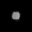

Loss: 0.654 (L1: 0.508, MSE: 0.368, SSIM: 0.992):  16%|▉     | 1328/8473 [00:06<00:37, 189.63step/s]

JPG image saved to: results/step_01300.jpg


Loss: 0.654 (L1: 0.508, MSE: 0.368, SSIM: 0.991):  16%|▉     | 1388/8473 [00:07<00:37, 189.26step/s]

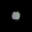

Loss: 0.654 (L1: 0.508, MSE: 0.368, SSIM: 0.991):  17%|█     | 1426/8473 [00:07<00:39, 179.53step/s]

JPG image saved to: results/step_01400.jpg


Loss: 0.653 (L1: 0.508, MSE: 0.368, SSIM: 0.991):  18%|█     | 1498/8473 [00:07<00:42, 164.85step/s]

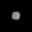

Loss: 0.653 (L1: 0.508, MSE: 0.368, SSIM: 0.991):  18%|█     | 1534/8473 [00:08<00:41, 168.67step/s]

JPG image saved to: results/step_01500.jpg


Loss: 0.653 (L1: 0.508, MSE: 0.367, SSIM: 0.990):  19%|█     | 1588/8473 [00:08<00:39, 173.36step/s]

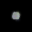

Loss: 0.653 (L1: 0.508, MSE: 0.367, SSIM: 0.990):  19%|█▏    | 1624/8473 [00:08<00:39, 173.13step/s]

JPG image saved to: results/step_01600.jpg


Loss: 0.652 (L1: 0.507, MSE: 0.367, SSIM: 0.989):  20%|█▏    | 1696/8473 [00:09<00:38, 174.00step/s]

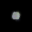

Loss: 0.652 (L1: 0.507, MSE: 0.367, SSIM: 0.989):  20%|█▏    | 1736/8473 [00:09<00:36, 183.36step/s]

JPG image saved to: results/step_01700.jpg


Loss: 0.652 (L1: 0.507, MSE: 0.367, SSIM: 0.988):  21%|█▎    | 1792/8473 [00:09<00:37, 176.33step/s]

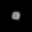

Loss: 0.652 (L1: 0.507, MSE: 0.367, SSIM: 0.988):  22%|█▎    | 1828/8473 [00:09<00:37, 175.62step/s]

JPG image saved to: results/step_01800.jpg


Loss: 0.651 (L1: 0.507, MSE: 0.367, SSIM: 0.988):  22%|█▎    | 1885/8473 [00:10<00:37, 175.85step/s]

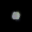

Loss: 0.651 (L1: 0.507, MSE: 0.367, SSIM: 0.987):  23%|█▎    | 1924/8473 [00:10<00:36, 181.60step/s]

JPG image saved to: results/step_01900.jpg


Loss: 0.651 (L1: 0.507, MSE: 0.367, SSIM: 0.987):  24%|█▍    | 1992/8473 [00:10<00:31, 206.43step/s]

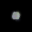

Loss: 0.651 (L1: 0.506, MSE: 0.366, SSIM: 0.987):  24%|█▍    | 2036/8473 [00:10<00:30, 211.55step/s]

JPG image saved to: results/step_02000.jpg


Loss: 0.650 (L1: 0.506, MSE: 0.366, SSIM: 0.986):  25%|█▍    | 2082/8473 [00:11<00:29, 217.28step/s]

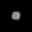

Loss: 0.650 (L1: 0.506, MSE: 0.366, SSIM: 0.986):  25%|█▌    | 2127/8473 [00:11<00:29, 217.92step/s]

JPG image saved to: results/step_02100.jpg


Loss: 0.650 (L1: 0.506, MSE: 0.366, SSIM: 0.985):  26%|█▌    | 2194/8473 [00:11<00:29, 214.74step/s]

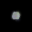

Loss: 0.650 (L1: 0.506, MSE: 0.366, SSIM: 0.985):  27%|█▌    | 2257/8473 [00:11<00:23, 264.29step/s]

JPG image saved to: results/step_02200.jpg


Loss: 0.650 (L1: 0.506, MSE: 0.366, SSIM: 0.984):  27%|█▌    | 2290/8473 [00:11<00:21, 283.07step/s]

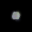

Loss: 0.649 (L1: 0.505, MSE: 0.366, SSIM: 0.984):  28%|█▋    | 2352/8473 [00:12<00:20, 293.48step/s]

JPG image saved to: results/step_02300.jpg


Loss: 0.649 (L1: 0.505, MSE: 0.366, SSIM: 0.984):  28%|█▋    | 2382/8473 [00:12<00:21, 279.58step/s]

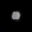

Loss: 0.649 (L1: 0.505, MSE: 0.365, SSIM: 0.983):  29%|█▋    | 2438/8473 [00:12<00:24, 246.22step/s]

JPG image saved to: results/step_02400.jpg


Loss: 0.648 (L1: 0.505, MSE: 0.365, SSIM: 0.983):  29%|█▊    | 2489/8473 [00:12<00:24, 239.58step/s]

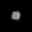

Loss: 0.648 (L1: 0.505, MSE: 0.365, SSIM: 0.982):  30%|█▊    | 2538/8473 [00:12<00:26, 224.09step/s]

JPG image saved to: results/step_02500.jpg


Loss: 0.648 (L1: 0.505, MSE: 0.365, SSIM: 0.982):  30%|█▊    | 2584/8473 [00:13<00:27, 216.93step/s]

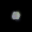

Loss: 0.648 (L1: 0.505, MSE: 0.365, SSIM: 0.982):  31%|█▊    | 2627/8473 [00:13<00:30, 192.20step/s]

JPG image saved to: results/step_02600.jpg


Loss: 0.647 (L1: 0.504, MSE: 0.365, SSIM: 0.981):  32%|█▉    | 2689/8473 [00:13<00:29, 197.00step/s]

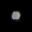

Loss: 0.647 (L1: 0.504, MSE: 0.365, SSIM: 0.981):  32%|█▉    | 2729/8473 [00:13<00:30, 188.49step/s]

JPG image saved to: results/step_02700.jpg


Loss: 0.647 (L1: 0.504, MSE: 0.365, SSIM: 0.980):  33%|█▉    | 2792/8473 [00:14<00:28, 200.79step/s]

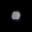

Loss: 0.647 (L1: 0.504, MSE: 0.364, SSIM: 0.980):  33%|██    | 2835/8473 [00:14<00:27, 202.23step/s]

JPG image saved to: results/step_02800.jpg


Loss: 0.646 (L1: 0.504, MSE: 0.364, SSIM: 0.979):  34%|██    | 2900/8473 [00:14<00:26, 208.68step/s]

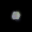

Loss: 0.646 (L1: 0.504, MSE: 0.364, SSIM: 0.979):  34%|██    | 2921/8473 [00:14<00:27, 200.50step/s]

JPG image saved to: results/step_02900.jpg


Loss: 0.646 (L1: 0.503, MSE: 0.364, SSIM: 0.978):  35%|██    | 2985/8473 [00:15<00:26, 203.70step/s]

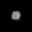

Loss: 0.646 (L1: 0.503, MSE: 0.364, SSIM: 0.978):  36%|██▏   | 3028/8473 [00:15<00:26, 205.67step/s]

JPG image saved to: results/step_03000.jpg


Loss: 0.645 (L1: 0.503, MSE: 0.364, SSIM: 0.977):  37%|██▏   | 3094/8473 [00:15<00:25, 212.81step/s]

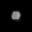

Loss: 0.645 (L1: 0.503, MSE: 0.364, SSIM: 0.977):  37%|██▏   | 3137/8473 [00:15<00:26, 199.56step/s]

JPG image saved to: results/step_03100.jpg


Loss: 0.645 (L1: 0.503, MSE: 0.364, SSIM: 0.977):  38%|██▎   | 3180/8473 [00:16<00:25, 204.10step/s]

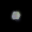

Loss: 0.645 (L1: 0.503, MSE: 0.363, SSIM: 0.976):  38%|██▎   | 3222/8473 [00:16<00:25, 205.13step/s]

JPG image saved to: results/step_03200.jpg


Loss: 0.644 (L1: 0.502, MSE: 0.363, SSIM: 0.976):  39%|██▎   | 3284/8473 [00:16<00:26, 193.08step/s]

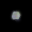

Loss: 0.644 (L1: 0.502, MSE: 0.363, SSIM: 0.975):  39%|██▎   | 3324/8473 [00:16<00:27, 190.13step/s]

JPG image saved to: results/step_03300.jpg


Loss: 0.644 (L1: 0.502, MSE: 0.363, SSIM: 0.975):  40%|██▍   | 3383/8473 [00:17<00:27, 185.98step/s]

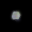

Loss: 0.643 (L1: 0.502, MSE: 0.363, SSIM: 0.974):  40%|██▍   | 3421/8473 [00:17<00:28, 177.56step/s]

JPG image saved to: results/step_03400.jpg


Loss: 0.643 (L1: 0.502, MSE: 0.363, SSIM: 0.974):  41%|██▍   | 3493/8473 [00:17<00:29, 170.04step/s]

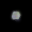

Loss: 0.643 (L1: 0.501, MSE: 0.363, SSIM: 0.973):  42%|██▍   | 3529/8473 [00:18<00:29, 170.01step/s]

JPG image saved to: results/step_03500.jpg


Loss: 0.643 (L1: 0.501, MSE: 0.362, SSIM: 0.973):  42%|██▌   | 3591/8473 [00:18<00:25, 190.97step/s]

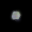

Loss: 0.642 (L1: 0.501, MSE: 0.362, SSIM: 0.972):  43%|██▌   | 3631/8473 [00:18<00:25, 187.53step/s]

JPG image saved to: results/step_03600.jpg


Loss: 0.642 (L1: 0.501, MSE: 0.362, SSIM: 0.972):  44%|██▌   | 3697/8473 [00:18<00:23, 205.10step/s]

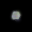

Loss: 0.642 (L1: 0.501, MSE: 0.362, SSIM: 0.972):  44%|██▋   | 3740/8473 [00:19<00:22, 207.98step/s]

JPG image saved to: results/step_03700.jpg


Loss: 0.641 (L1: 0.501, MSE: 0.362, SSIM: 0.971):  45%|██▋   | 3784/8473 [00:19<00:22, 211.55step/s]

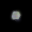

Loss: 0.641 (L1: 0.500, MSE: 0.362, SSIM: 0.971):  45%|██▋   | 3828/8473 [00:19<00:21, 212.26step/s]

JPG image saved to: results/step_03800.jpg


Loss: 0.641 (L1: 0.500, MSE: 0.362, SSIM: 0.970):  46%|██▊   | 3894/8473 [00:19<00:21, 209.28step/s]

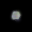

Loss: 0.641 (L1: 0.500, MSE: 0.361, SSIM: 0.970):  47%|██▊   | 3941/8473 [00:20<00:21, 214.14step/s]

JPG image saved to: results/step_03900.jpg


Loss: 0.640 (L1: 0.500, MSE: 0.361, SSIM: 0.969):  47%|██▊   | 3989/8473 [00:20<00:20, 223.70step/s]

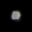

Loss: 0.640 (L1: 0.500, MSE: 0.361, SSIM: 0.969):  48%|██▊   | 4038/8473 [00:20<00:18, 233.83step/s]

JPG image saved to: results/step_04000.jpg


Loss: 0.640 (L1: 0.499, MSE: 0.361, SSIM: 0.968):  48%|██▉   | 4070/8473 [00:20<00:17, 257.31step/s]

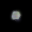

Loss: 0.639 (L1: 0.499, MSE: 0.361, SSIM: 0.967):  49%|██▉   | 4133/8473 [00:20<00:15, 283.08step/s]

JPG image saved to: results/step_04100.jpg


Loss: 0.639 (L1: 0.499, MSE: 0.361, SSIM: 0.967):  50%|██▉   | 4195/8473 [00:20<00:14, 291.99step/s]

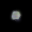

Loss: 0.639 (L1: 0.499, MSE: 0.361, SSIM: 0.966):  50%|███   | 4258/8473 [00:21<00:14, 300.26step/s]

JPG image saved to: results/step_04200.jpg


Loss: 0.639 (L1: 0.499, MSE: 0.361, SSIM: 0.966):  51%|███   | 4290/8473 [00:21<00:13, 304.05step/s]

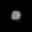

Loss: 0.638 (L1: 0.499, MSE: 0.360, SSIM: 0.966):  51%|███   | 4350/8473 [00:21<00:14, 282.01step/s]

JPG image saved to: results/step_04300.jpg


Loss: 0.638 (L1: 0.498, MSE: 0.360, SSIM: 0.965):  52%|███   | 4379/8473 [00:21<00:16, 252.15step/s]

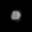

Loss: 0.638 (L1: 0.498, MSE: 0.360, SSIM: 0.965):  52%|███▏  | 4430/8473 [00:21<00:18, 222.02step/s]

JPG image saved to: results/step_04400.jpg


Loss: 0.637 (L1: 0.498, MSE: 0.360, SSIM: 0.964):  53%|███▏  | 4495/8473 [00:22<00:19, 200.38step/s]

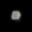

Loss: 0.637 (L1: 0.498, MSE: 0.360, SSIM: 0.964):  54%|███▏  | 4537/8473 [00:22<00:19, 197.41step/s]

JPG image saved to: results/step_04500.jpg


Loss: 0.637 (L1: 0.498, MSE: 0.360, SSIM: 0.963):  54%|███▎  | 4598/8473 [00:22<00:19, 198.65step/s]

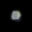

Loss: 0.637 (L1: 0.498, MSE: 0.360, SSIM: 0.963):  55%|███▎  | 4618/8473 [00:22<00:19, 193.12step/s]

JPG image saved to: results/step_04600.jpg


Loss: 0.636 (L1: 0.497, MSE: 0.359, SSIM: 0.962):  55%|███▎  | 4696/8473 [00:23<00:20, 186.35step/s]

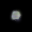

Loss: 0.636 (L1: 0.497, MSE: 0.359, SSIM: 0.962):  56%|███▎  | 4735/8473 [00:23<00:19, 187.25step/s]

JPG image saved to: results/step_04700.jpg


Loss: 0.636 (L1: 0.497, MSE: 0.359, SSIM: 0.961):  57%|███▍  | 4793/8473 [00:23<00:19, 184.55step/s]

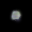

Loss: 0.635 (L1: 0.497, MSE: 0.359, SSIM: 0.961):  57%|███▍  | 4831/8473 [00:24<00:19, 186.71step/s]

JPG image saved to: results/step_04800.jpg


Loss: 0.635 (L1: 0.497, MSE: 0.359, SSIM: 0.960):  58%|███▍  | 4893/8473 [00:24<00:18, 197.10step/s]

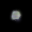

Loss: 0.635 (L1: 0.497, MSE: 0.359, SSIM: 0.960):  58%|███▍  | 4934/8473 [00:24<00:18, 190.83step/s]

JPG image saved to: results/step_04900.jpg


Loss: 0.635 (L1: 0.496, MSE: 0.359, SSIM: 0.959):  59%|███▌  | 4995/8473 [00:24<00:17, 193.48step/s]

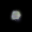

Loss: 0.634 (L1: 0.496, MSE: 0.359, SSIM: 0.959):  59%|███▌  | 5035/8473 [00:25<00:18, 182.49step/s]

JPG image saved to: results/step_05000.jpg


Loss: 0.634 (L1: 0.496, MSE: 0.358, SSIM: 0.958):  60%|███▌  | 5092/8473 [00:25<00:18, 180.08step/s]

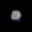

Loss: 0.634 (L1: 0.496, MSE: 0.358, SSIM: 0.958):  61%|███▋  | 5129/8473 [00:25<00:19, 170.12step/s]

JPG image saved to: results/step_05100.jpg


Loss: 0.633 (L1: 0.496, MSE: 0.358, SSIM: 0.957):  61%|███▋  | 5183/8473 [00:26<00:19, 168.76step/s]

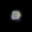

Loss: 0.633 (L1: 0.495, MSE: 0.358, SSIM: 0.957):  62%|███▋  | 5218/8473 [00:26<00:19, 167.24step/s]

JPG image saved to: results/step_05200.jpg


Loss: 0.633 (L1: 0.495, MSE: 0.358, SSIM: 0.956):  62%|███▋  | 5279/8473 [00:26<00:16, 192.11step/s]

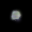

Loss: 0.633 (L1: 0.495, MSE: 0.358, SSIM: 0.955):  63%|███▊  | 5323/8473 [00:26<00:15, 202.84step/s]

JPG image saved to: results/step_05300.jpg


Loss: 0.632 (L1: 0.495, MSE: 0.358, SSIM: 0.955):  64%|███▊  | 5389/8473 [00:27<00:14, 210.15step/s]

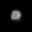

Loss: 0.632 (L1: 0.495, MSE: 0.357, SSIM: 0.955):  64%|███▊  | 5433/8473 [00:27<00:14, 210.11step/s]

JPG image saved to: results/step_05400.jpg


Loss: 0.632 (L1: 0.495, MSE: 0.357, SSIM: 0.954):  65%|███▉  | 5499/8473 [00:27<00:14, 209.33step/s]

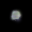

Loss: 0.631 (L1: 0.494, MSE: 0.357, SSIM: 0.954):  65%|███▉  | 5520/8473 [00:27<00:14, 197.13step/s]

JPG image saved to: results/step_05500.jpg


Loss: 0.631 (L1: 0.494, MSE: 0.357, SSIM: 0.953):  66%|███▉  | 5580/8473 [00:27<00:11, 247.43step/s]

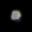

Loss: 0.631 (L1: 0.494, MSE: 0.357, SSIM: 0.953):  66%|███▉  | 5630/8473 [00:28<00:12, 228.30step/s]

JPG image saved to: results/step_05600.jpg


Loss: 0.630 (L1: 0.494, MSE: 0.357, SSIM: 0.952):  67%|████  | 5681/8473 [00:28<00:11, 236.99step/s]

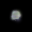

Loss: 0.630 (L1: 0.494, MSE: 0.357, SSIM: 0.952):  68%|████  | 5730/8473 [00:28<00:11, 237.51step/s]

JPG image saved to: results/step_05700.jpg


Loss: 0.630 (L1: 0.494, MSE: 0.357, SSIM: 0.951):  68%|████  | 5781/8473 [00:28<00:11, 240.57step/s]

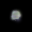

Loss: 0.630 (L1: 0.493, MSE: 0.356, SSIM: 0.951):  69%|████▏ | 5831/8473 [00:28<00:11, 231.41step/s]

JPG image saved to: results/step_05800.jpg


Loss: 0.629 (L1: 0.493, MSE: 0.356, SSIM: 0.950):  70%|████▏ | 5900/8473 [00:29<00:11, 216.85step/s]

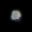

Loss: 0.629 (L1: 0.493, MSE: 0.356, SSIM: 0.950):  70%|████▏ | 5922/8473 [00:29<00:12, 211.44step/s]

JPG image saved to: results/step_05900.jpg


Loss: 0.629 (L1: 0.493, MSE: 0.356, SSIM: 0.949):  71%|████▏ | 5987/8473 [00:29<00:12, 198.96step/s]

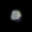

Loss: 0.629 (L1: 0.493, MSE: 0.356, SSIM: 0.949):  71%|████▎ | 6028/8473 [00:29<00:12, 196.19step/s]

JPG image saved to: results/step_06000.jpg


Loss: 0.628 (L1: 0.493, MSE: 0.356, SSIM: 0.948):  72%|████▎ | 6090/8473 [00:30<00:11, 198.94step/s]

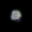

Loss: 0.628 (L1: 0.492, MSE: 0.356, SSIM: 0.948):  72%|████▎ | 6131/8473 [00:30<00:11, 197.95step/s]

JPG image saved to: results/step_06100.jpg


Loss: 0.628 (L1: 0.492, MSE: 0.355, SSIM: 0.947):  73%|████▍ | 6194/8473 [00:30<00:11, 203.84step/s]

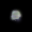

Loss: 0.628 (L1: 0.492, MSE: 0.355, SSIM: 0.947):  74%|████▍ | 6236/8473 [00:30<00:11, 193.83step/s]

JPG image saved to: results/step_06200.jpg


Loss: 0.627 (L1: 0.492, MSE: 0.355, SSIM: 0.946):  74%|████▍ | 6297/8473 [00:31<00:10, 198.07step/s]

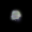

Loss: 0.627 (L1: 0.492, MSE: 0.355, SSIM: 0.946):  75%|████▍ | 6317/8473 [00:31<00:11, 185.92step/s]

JPG image saved to: results/step_06300.jpg


Loss: 0.627 (L1: 0.492, MSE: 0.355, SSIM: 0.945):  76%|████▌ | 6398/8473 [00:31<00:10, 194.50step/s]

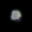

Loss: 0.626 (L1: 0.491, MSE: 0.355, SSIM: 0.945):  76%|████▌ | 6439/8473 [00:32<00:10, 196.55step/s]

JPG image saved to: results/step_06400.jpg


Loss: 0.626 (L1: 0.491, MSE: 0.355, SSIM: 0.944):  77%|████▌ | 6499/8473 [00:32<00:10, 184.09step/s]

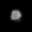

Loss: 0.626 (L1: 0.491, MSE: 0.355, SSIM: 0.944):  77%|████▌ | 6518/8473 [00:32<00:11, 176.84step/s]

JPG image saved to: results/step_06500.jpg


Loss: 0.626 (L1: 0.491, MSE: 0.354, SSIM: 0.944):  78%|████▋ | 6596/8473 [00:32<00:10, 182.85step/s]

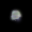

Loss: 0.625 (L1: 0.491, MSE: 0.354, SSIM: 0.943):  78%|████▋ | 6634/8473 [00:33<00:10, 178.32step/s]

JPG image saved to: results/step_06600.jpg


Loss: 0.625 (L1: 0.491, MSE: 0.354, SSIM: 0.943):  79%|████▋ | 6693/8473 [00:33<00:09, 184.95step/s]

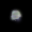

Loss: 0.625 (L1: 0.490, MSE: 0.354, SSIM: 0.942):  79%|████▊ | 6730/8473 [00:33<00:09, 175.74step/s]

JPG image saved to: results/step_06700.jpg


Loss: 0.625 (L1: 0.490, MSE: 0.354, SSIM: 0.942):  80%|████▊ | 6784/8473 [00:34<00:09, 174.56step/s]

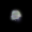

Loss: 0.624 (L1: 0.490, MSE: 0.354, SSIM: 0.941):  81%|████▊ | 6827/8473 [00:34<00:08, 192.89step/s]

JPG image saved to: results/step_06800.jpg


Loss: 0.624 (L1: 0.490, MSE: 0.354, SSIM: 0.941):  81%|████▉ | 6893/8473 [00:34<00:07, 208.30step/s]

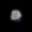

Loss: 0.624 (L1: 0.490, MSE: 0.354, SSIM: 0.941):  82%|████▉ | 6936/8473 [00:34<00:07, 208.88step/s]

JPG image saved to: results/step_06900.jpg


Loss: 0.624 (L1: 0.490, MSE: 0.353, SSIM: 0.940):  82%|████▉ | 6980/8473 [00:34<00:07, 211.77step/s]

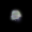

Loss: 0.623 (L1: 0.490, MSE: 0.353, SSIM: 0.940):  83%|████▉ | 7023/8473 [00:35<00:06, 208.82step/s]

JPG image saved to: results/step_07000.jpg


Loss: 0.623 (L1: 0.489, MSE: 0.353, SSIM: 0.939):  84%|█████ | 7086/8473 [00:35<00:06, 198.53step/s]

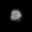

Loss: 0.623 (L1: 0.489, MSE: 0.353, SSIM: 0.939):  84%|█████ | 7126/8473 [00:35<00:06, 195.43step/s]

JPG image saved to: results/step_07100.jpg


Loss: 0.622 (L1: 0.489, MSE: 0.353, SSIM: 0.938):  85%|█████ | 7196/8473 [00:35<00:05, 218.47step/s]

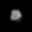

Loss: 0.622 (L1: 0.489, MSE: 0.353, SSIM: 0.938):  85%|█████▏| 7240/8473 [00:36<00:05, 211.03step/s]

JPG image saved to: results/step_07200.jpg


Loss: 0.622 (L1: 0.489, MSE: 0.353, SSIM: 0.937):  86%|█████▏| 7283/8473 [00:36<00:05, 207.41step/s]

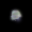

Loss: 0.622 (L1: 0.489, MSE: 0.353, SSIM: 0.937):  86%|█████▏| 7325/8473 [00:36<00:05, 200.26step/s]

JPG image saved to: results/step_07300.jpg


Loss: 0.621 (L1: 0.488, MSE: 0.352, SSIM: 0.936):  87%|█████▏| 7386/8473 [00:36<00:05, 185.21step/s]

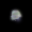

Loss: 0.621 (L1: 0.488, MSE: 0.352, SSIM: 0.936):  88%|█████▎| 7424/8473 [00:37<00:05, 186.16step/s]

JPG image saved to: results/step_07400.jpg


Loss: 0.621 (L1: 0.488, MSE: 0.352, SSIM: 0.935):  88%|█████▎| 7482/8473 [00:37<00:05, 182.12step/s]

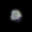

Loss: 0.621 (L1: 0.488, MSE: 0.352, SSIM: 0.936):  89%|█████▎| 7519/8473 [00:37<00:05, 174.73step/s]

JPG image saved to: results/step_07500.jpg


Loss: 0.621 (L1: 0.488, MSE: 0.352, SSIM: 0.935):  90%|█████▍| 7593/8473 [00:38<00:04, 176.46step/s]

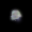

Loss: 0.620 (L1: 0.488, MSE: 0.352, SSIM: 0.935):  90%|█████▍| 7632/8473 [00:38<00:04, 182.75step/s]

JPG image saved to: results/step_07600.jpg


Loss: 0.620 (L1: 0.488, MSE: 0.352, SSIM: 0.934):  91%|█████▍| 7692/8473 [00:38<00:04, 189.58step/s]

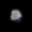

Loss: 0.620 (L1: 0.488, MSE: 0.352, SSIM: 0.934):  91%|█████▍| 7730/8473 [00:38<00:04, 181.12step/s]

JPG image saved to: results/step_07700.jpg


Loss: 0.620 (L1: 0.487, MSE: 0.352, SSIM: 0.933):  92%|█████▌| 7787/8473 [00:39<00:03, 176.73step/s]

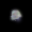

Loss: 0.619 (L1: 0.487, MSE: 0.351, SSIM: 0.933):  92%|█████▌| 7824/8473 [00:39<00:03, 178.38step/s]

JPG image saved to: results/step_07800.jpg


Loss: 0.619 (L1: 0.487, MSE: 0.351, SSIM: 0.933):  93%|█████▌| 7898/8473 [00:39<00:03, 172.26step/s]

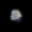

Loss: 0.619 (L1: 0.487, MSE: 0.351, SSIM: 0.932):  94%|█████▌| 7934/8473 [00:39<00:03, 171.47step/s]

JPG image saved to: results/step_07900.jpg


Loss: 0.619 (L1: 0.487, MSE: 0.351, SSIM: 0.932):  94%|█████▋| 7989/8473 [00:40<00:02, 175.58step/s]

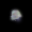

Loss: 0.619 (L1: 0.487, MSE: 0.351, SSIM: 0.932):  95%|█████▋| 8030/8473 [00:40<00:02, 187.09step/s]

JPG image saved to: results/step_08000.jpg


Loss: 0.618 (L1: 0.487, MSE: 0.351, SSIM: 0.931):  96%|█████▋| 8092/8473 [00:40<00:01, 199.51step/s]

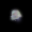

Loss: 0.618 (L1: 0.486, MSE: 0.351, SSIM: 0.931):  96%|█████▊| 8135/8473 [00:41<00:01, 206.31step/s]

JPG image saved to: results/step_08100.jpg


Loss: 0.618 (L1: 0.486, MSE: 0.351, SSIM: 0.930):  97%|█████▊| 8179/8473 [00:41<00:01, 211.61step/s]

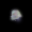

Loss: 0.618 (L1: 0.486, MSE: 0.351, SSIM: 0.930):  97%|█████▊| 8223/8473 [00:41<00:01, 212.14step/s]

JPG image saved to: results/step_08200.jpg


Loss: 0.617 (L1: 0.486, MSE: 0.350, SSIM: 0.930):  98%|█████▊| 8290/8473 [00:41<00:00, 217.10step/s]

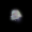

Loss: 0.617 (L1: 0.486, MSE: 0.350, SSIM: 0.929):  98%|█████▉| 8338/8473 [00:41<00:00, 216.88step/s]

JPG image saved to: results/step_08300.jpg


Loss: 0.617 (L1: 0.486, MSE: 0.350, SSIM: 0.929):  99%|█████▉| 8396/8473 [00:42<00:00, 250.37step/s]

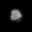

Loss: 0.617 (L1: 0.486, MSE: 0.350, SSIM: 0.928):  99%|█████▉| 8422/8473 [00:42<00:00, 237.52step/s]

JPG image saved to: results/step_08400.jpg


Loss: 0.617 (L1: 0.485, MSE: 0.350, SSIM: 0.928): 100%|██████| 8473/8473 [00:42<00:00, 199.36step/s]


GIF saved to: results/animation.gif


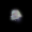

[I 2025-01-06 06:11:52,553] Trial 7 finished with value: 0.4854642450809479 and parameters: {'loss_weight_l1': 0.48133148909567036, 'loss_weight_mse': 0.5031537178184011, 'loss_weight_ssim': 0.6328167215371595, 'scale_regulation': 0.1, 'opacity_regulation': 0.5, 'init_type': 'random', 'num_points': 256, 'extent': 1.0, 'init_scale': 0.6835854888885989, 'init_opacity': 0.21040242587307367, 'max_steps': 8473, 'learning_rate': 2.6183271342049026e-05, 'model_type': '2dgs', 'bilateral_grid': False}. Best is trial 1 with value: 0.10806117206811905.


JPG image saved to: results/final.jpg
Final loss: 0.6165645122528076
Total Time: Rasterization: 6.247s, Backward: 16.965s
Trial 7 finished with value: 0.4854642450809479 and parameters: {'loss_weight_l1': 0.48133148909567036, 'loss_weight_mse': 0.5031537178184011, 'loss_weight_ssim': 0.6328167215371595, 'scale_regulation': 0.1, 'opacity_regulation': 0.5, 'init_type': 'random', 'num_points': 256, 'extent': 1.0, 'init_scale': 0.6835854888885989, 'init_opacity': 0.21040242587307367, 'max_steps': 8473, 'learning_rate': 2.6183271342049026e-05, 'model_type': '2dgs', 'bilateral_grid': False}. Best is trial 1 with value: 0.10806117206811905.
Trial 7 finished with value: 0.4854642450809479 and parameters: {'loss_weight_l1': 0.48133148909567036, 'loss_weight_mse': 0.5031537178184011, 'loss_weight_ssim': 0.6328167215371595, 'scale_regulation': 0.1, 'opacity_regulation': 0.5, 'init_type': 'random', 'num_points': 256, 'extent': 1.0, 'init_scale': 0.6835854888885989, 'init_opacity': 0.21040242587307

[I 2025-01-06 06:11:52,773] Trial 8 pruned. Invalid hyperparameter combination


Trial 8 pruned. Invalid hyperparameter combination
Trial 8 pruned. Invalid hyperparameter combination
Trial 8 pruned. Invalid hyperparameter combination
Trial 8 pruned. Invalid hyperparameter combination


[I 2025-01-06 06:11:52,992] Trial 9 pruned. Invalid hyperparameter combination


Trial 9 pruned. Invalid hyperparameter combination
Trial 9 pruned. Invalid hyperparameter combination
Trial 9 pruned. Invalid hyperparameter combination
Trial 9 pruned. Invalid hyperparameter combination
Best hyperparameters found:
{'loss_weight_l1': 0.8792750902433263, 'loss_weight_mse': 0.1773429447087944, 'loss_weight_ssim': 0.3618847897862979, 'scale_regulation': 0.5, 'opacity_regulation': 1.0, 'init_type': 'knn', 'num_points': 1024, 'extent': 2.0, 'init_scale': 1.1466352193045959, 'init_opacity': 0.7835192836462006, 'max_steps': 944, 'learning_rate': 0.0007992505573535983, 'model_type': '3dgs', 'bilateral_grid': False}


In [19]:
run_optimization()

In [25]:
!optuna-dashboard sqlite:///test-study.db --port 8088

Listening on http://127.0.0.1:8088/
Hit Ctrl-C to quit.

^C
Traceback (most recent call last):
  File "/usr/local/bin/optuna-dashboard", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/optuna_dashboard/_cli.py", line 140, in main
    run_wsgiref(app, args.host, args.port, args.quiet)
  File "/usr/local/lib/python3.10/dist-packages/optuna_dashboard/_cli.py", line 44, in run_wsgiref
    httpd.serve_forever()
  File "/usr/lib/python3.10/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt


In [27]:
!pip install jupyterlab-optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 11.0 MB/s eta 0:00:00a 0:00:01
done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... one
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jupyterlab-optuna: filename=jupyterlab_optuna-0.1.0-py3-none-any.whl size=3608000 sha256=b75f585fd147a45ddcf95b8b62bc8149c9dcc876739adb78c1c597eebf0b4321
  Stored in directory: /root/.cache/pip/wheels/9a/9b/ca/eb4257d7ea94f5c94b3117fd9c2cb01076558ec93990308073
Successfully built jupyterlab-optuna


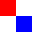

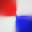

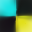

In [21]:
from utils import visualize_tensor

visualize_tensor(image)
visualize_tensor(r)
visualize_tensor(image.cpu() - r.cpu())